In [ ]:
#@title Библиотеки
import ast
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

import os
import h5py
import time
from tqdm.notebook import tqdm,trange
import json
import csv

from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, models, transforms
import torchvision
import torch
from torch import nn

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu

from collections import Counter

In [ ]:
!ls /kaggle/input

In [ ]:
import numpy as np
import os
import h5py
import numpy as np

h1 = h5py.File('/kaggle/input/all-info/big_clean_train_images.hdf5')
images_train = h1['images_dataset'][:]

In [ ]:
h2 = h5py.File('/kaggle/input/all-info/train_images.hdf5')
images_train2 = h2['images_dataset'][:]

In [ ]:
'''import numpy as np

res = np.concatenate((images_train,images_train2))
res.shape'''

In [ ]:
with h5py.File(os.path.join('train.hdf5'), 'a') as h:
  #Create dataset inside HDF5 file to store images
  images = h.create_dataset('images_dataset',  data=np.concatenate((images_train,images_train2)))

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
!zip -r 'file.zip' 'train.hdf5' 

[Загрузка данных](#1)

<a id="1"></a>
# Загрузка данных

## russian (no imgs)

In [ ]:
dfo = pd.read_csv('ozon.csv')
dfo.head()

In [ ]:
%%capture
!pip install selenium
!apt update
!apt install chromium-chromedriver

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# импорт библиотеки webdriver для работы с динамическими аблицами selenium
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.page_load_strategy = 'eager'

# open it, go to a website, and get results
wd = webdriver.Chrome(options=options)

wd.set_window_size(1920, 1080)

In [ ]:
session = requests.Session()
product_ids = []

for i in trange(1,101):
  resp = session.get(f'https://catalog.wb.ru/catalog/dresses/catalog?appType=1&kind=2&locale=ru&page={i}&sort=popular')
  bsoup = BeautifulSoup(resp.text, "html.parser")

  site_json=json.loads(bsoup.text)
  product_ids.extend([product.get('id') for product in site_json['data']['products']])

In [ ]:
wd.save_screenshot('hey.png')

In [ ]:
session = requests.Session()

resp = session.get(f'https://www.lamoda.ru/c/6647/home_accs-tovarydlyadoma/?sitelink=topmenuW&l=1')
bsoup=BeautifulSoup(resp.text, "html.parser")

In [ ]:
ids = ['https://www.lamoda.ru/'+i['href'] for i in bsoup.findAll('a',{'class':['x-product-card__link', 'x-product-card__hit-area']})]

In [ ]:
ids[2]

In [ ]:
resp = session.get(ids[2])
bsoup=BeautifulSoup(resp.text, "html.parser")

In [ ]:
bsoup.find('meta',{'property':"og:image"})['content']

In [ ]:
bsoup.find('div',{'class':'x-premium-product-title__model-name'}).text

In [ ]:
bsoup.findAll('script',{'type':'application/ld+json'})[1].text

In [ ]:
str(bsoup).index('Комплект постельного белья выполнен')

In [ ]:
str(bsoup)[88003:]

In [ ]:
bsoup

In [ ]:
product_ids[10]

In [ ]:
print(bsoup.find('div',{'class':'_1uLae'}))

In [ ]:
from selenium.common.exceptions import TimeoutException, NoSuchElementException

try:
  e = WebDriverWait(wd, 5).until(EC.presence_of_element_located((By.CLASS_NAME, "collapsable__content.j-description")))
  r = wd.find_elements(By.CSS_SELECTOR,'h1.same-part-kt__header')[1].find_elements(By.TAG_NAME,'span')[-1].text
  print(r)
except NoSuchElementException as e:
  print(e)

In [ ]:
def get_product_info(product_id): 
    '''
    Получить название, описание и ссылку на фото товара
    Аргументы:
      product_id -- id товара
    Возвращает:
      [id, название, описание, ссылка на фото]
    '''
    print(f'working on #{product_id}')

    wd.get(f'https://www.wildberries.ru/catalog/{product_id}/detail.aspx')
    time.sleep(1)

    try:
        descr_div = WebDriverWait(wd, 6).until(
              EC.presence_of_element_located((By.CLASS_NAME, "collapsable__content.j-description"))
          )
        descr = descr_div.find_element(By.TAG_NAME,'p').text

    # иногда может не быть описания; возвращаем пустые строки
        if descr:
            title = wd.find_elements(By.CSS_SELECTOR,'h1.same-part-kt__header')[1].find_elements(By.TAG_NAME,'span')[-1].text
            img_link = wd.find_element(By.CLASS_NAME,'photo-zoom__preview').get_attribute('src')
        else:
            title,descr,img_link = '','',''

    except TimeoutException:
        print('time ',product_id)
        title,descr,img_link = '','',''
    except NoSuchElementException:
        print('no_el ',product_id)
        title,descr,img_link = '','',''

    print(title)
    with open('/content/drive/MyDrive/master/project/wb.csv', 'a', encoding='UTF8') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow([product_id,title,descr,img_link])

31 none,39 eager, 41 normal

In [ ]:
import concurrent.futures


with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for product_id in product_ids[:30]:
        futures.append(executor.submit(get_product_info, product_id))
    for future in concurrent.futures.as_completed(futures):
        pass

In [ ]:
d = pd.read_csv('/content/drive/MyDrive/master/project/wb.csv',sep='\t',header=None)
print(d.shape)


In [ ]:
d

In [ ]:
#@title
# screenshot всю страницу

wd.get(f'https://www.wildberries.ru/catalog/{product_ids[2]}/detail.aspx')
time.sleep(3)
original_size = wd.get_window_size()
required_width = wd.execute_script('return document.body.parentNode.scrollWidth')
required_height = wd.execute_script('return document.body.parentNode.scrollHeight')
wd.set_window_size(required_width, required_height)
# driver.save_screenshot(path)  # has scrollbar
wd.find_element_by_tag_name('body').screenshot('hello.png')



---



In [ ]:
%%capture
!wget https://www.dropbox.com/s/vyvjtwlm72r0q68/train_dataset%281%29.csv

df = pd.read_csv('train_dataset(1).csv')

In [ ]:
df.head(3)

In [ ]:
df[df.desc.str.len()>70].wb_cat_desc_name.value_counts()

## amazon

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Appliances.json.gz

In [ ]:
dfn = pd.read_json('meta_Appliances.json.gz',compression='gzip', lines=True)

In [ ]:
dfn[dfn.imageURL!='[]'].shape

In [ ]:
dfn[dfn.imageURL.astype(bool) & dfn.description.astype(bool)]['description'].iloc[9231]

## eng fashion

In [ ]:
%%capture
!wget https://www.dropbox.com/s/crnblyq4y54ahcr/meta_all_129927%281%29.json

# Чтение и обработка данных

In [ ]:
df_meta = pd.read_json('meta_all_129927(1).json')

In [ ]:
new = df_meta.drop_duplicates(subset='description',keep='first')

Вытянем ссылки на изображения товаров

In [ ]:
a = new['images'].apply(lambda x: x[0] if '0' in x[0].keys() else '')
a

In [ ]:
b = a[(~a.index.isin([113107]))&(a!='')]
b

In [ ]:
imgs = b.apply(lambda x: x['0'].split('?crop')[0]).to_list()
imgs[:5]

In [ ]:
new['link'] = b.apply(lambda x: x['0'].split('?crop')[0])

In [ ]:
c = new['link'].apply(lambda x: type(x))
c[c!=type('e')]
new = new[~new.index.isin([28989,55528,113107])]

In [ ]:
new[['id','title','description','link']].loc[:18819]
new['link'] = new['link'].apply(lambda x: x.split('sr3/')[-1])

In [ ]:
all = new[['id','title','description','link']].loc[:18819]
all.head()

In [ ]:
from tqdm.auto import tqdm

обучающая и тестовая выборки

# Загружаем картинки в hdf5

In [ ]:
train_l = imgs[:15001]
test_l = imgs[15001:18001]

In [ ]:
train_l[3994]

In [ ]:
'''with h5py.File(os.path.join('/content/drive/My Drive/master/project/train_images.hdf5'), 'a') as h:
  #Create dataset inside HDF5 file to store images
  images = h.create_dataset('images_dataset', (len(train_l), 3, 256, 256), dtype='uint8')
  # Read images
  for index,img_url in enumerate(tqdm(temp_train)):
    try:
      img = io.imread(img_url)
      img = np.array(Image.fromarray(img).resize((256,256)))
      img = img.transpose(2, 0, 1)
      images[index] = img
    except:
      print(index,img_url)
      continue'''
    
    

In [ ]:
'''# As a result, Pixel values are still in the range [0, 255], and are stored as unsigned 8-bit Ints

with h5py.File(os.path.join('/content/drive/My Drive/master/project/test_images.hdf5'), 'a') as h:
  #Create dataset inside HDF5 file to store images
  images = h.create_dataset('images_dataset', (len(test_l), 3, 256, 256), dtype='uint8')
  # Read images
  for index,img_url in enumerate(tqdm(temp_test)):
    try:
      img = io.imread(img_url)
      img = np.array(Image.fromarray(img).resize((256,256)))
      img = img.transpose(2, 0, 1)
      images[index] = img
    except:
      print(index,img_url)
      continue'''

##  финальный датафрейм

In [ ]:
temp_train = pd.Series(train_l)
temp_train = temp_train[~temp_train.index.isin([3994,8452,9970,10240,12770,14036,14609])]

In [ ]:
temp_test = pd.Series(test_l)
temp_test = temp_test[~temp_test.index.isin([1518,1764,1939,2631])]

In [ ]:
all['link'] = all['link'].apply(lambda x:'https://n.nordstrommedia.com/id/sr3/'+x)
#all['link'] = all['link'].apply(lambda x:x[1:])
all['train'] = 0
all.loc[all.link.isin(temp_train),'train'] = 1
all.loc[all.link.isin(temp_test),'train'] = 0

In [ ]:
all = all.loc[(all.link.isin(temp_train))|(all.link.isin(temp_test))]
all.head()

# Словарь + сохраняем фин.датасет

In [ ]:
train_desc = all[:15001]['description'].apply(lambda x:x.split())
train_desc.head()

In [ ]:
t = train_desc.apply(lambda x:len(x))
t.nlargest(10)

In [ ]:
t.value_counts()

In [ ]:
word_freq = Counter()
captions = []

def func(x):
  word_freq.update(x)
  captions.append(x)
  return x


train_desc.apply(func)

In [ ]:
# Create word map
words = [w for w in word_freq.keys() if word_freq[w] > 1]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [ ]:
'''import json
with open("/content/drive/MyDrive/master/project/data/word_map.json", "w") as outfile:
    json.dump(word_map, outfile)'''

In [ ]:
enc_captions = []
caption_lens = []

train_desc.iloc[0][:10]

In [ ]:
def count(x):
    caption = x.split()
    enc_caption = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in caption] + [
                          word_map['<end>']] + [word_map['<pad>']] * (116 - len(caption))
    
    return enc_caption

In [ ]:
all['encoded_desc'] = all['description'].apply(count)
all['len_desc'] =  all['description'].apply(lambda x: len(x.split()))

In [ ]:
all.head()

# Новый датасет и даталоадер

## Удалим ненужные картинки + поправим датасет

In [ ]:
'''
# test
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset'][:-4] # in df drop first 2 rows

with h5py.File('/content/drive/MyDrive/master/project/data/test_images.hdf5', 'w') as hf:
    hf.create_dataset("images_dataset",  data=images_test)
    
# train
h2 = h5py.File(os.path.join('/content/drive/MyDrive/master/project', 'train'+'_images.hdf5'), 'r')
temp = h2['images_dataset'][:-7]

images_train_half = np.concatenate((temp[:1187],temp[1188:2012]))
images_train = np.concatenate((images_train_half,temp[2013:]))
images_train.shape #(14992, 3, 256, 256)

with h5py.File('/content/drive/MyDrive/master/project/data/train_images.hdf5', 'w') as hf:
    hf.create_dataset("images_dataset",  data=images_train)'''

In [ ]:
'''temp_test = all[all.train==0].drop([1190,2021])
temp = pd.concat((all[all.train==1],temp_test))
temp.to_csv('/content/drive/MyDrive/master/project/data/all_df.csv',sep=';')'''

## Проверим соответствие

In [ ]:
descr = pd.read_csv(os.path.join('/content/drive/MyDrive/master/project/data','all_df.csv'),sep=';', index_col=0)
descr.shape

In [ ]:
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project/data', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset']

In [ ]:
plt.imshow(  (torch.FloatTensor(images_test[2011]/255.)).permute(1, 2, 0)  )

In [ ]:
descr[descr.train==0].iloc[2011]

## PyTorch Dataset class

In [ ]:
class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, csv_name='all_df.csv', split='train', dir='/content/drive/MyDrive/master/project/data',transform=None):
        self.split = split
        assert self.split in {'train', 'test'}

        self.dir = dir
        # Оставляем только нужную часть датафрейма
        df = pd.read_csv(os.path.join(self.dir,csv_name),sep=';')
        split_bool = self.split=='train'
        self.needed_df = df[df['train']==split_bool]

        self.h = h5py.File(os.path.join(self.dir, self.split+'_images.hdf5'), 'r')
        self.images = self.h['images_dataset']

        self.captions = self.needed_df['encoded_desc']
        self.caplens = self.needed_df['len_desc']

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx]/255.)
        if self.transform is not None:
            image = self.transform(image)

        caption = self.needed_df.iloc[idx]['encoded_desc']
        # was saved as str representation of list
        caption = torch.LongTensor(ast.literal_eval(caption))
        caplen = self.needed_df.iloc[idx]['len_desc']

        return image, caption, caplen

    def __len__(self):
        return self.needed_df.shape[0]

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'train', 
                       transform=transforms.Compose([normalize,
                                                     transforms.RandomHorizontalFlip(),
                                                     transforms.RandomRotation(degrees=(-10, 10))]))
                       ,batch_size=12, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'test', transform=transforms.Compose([normalize])),
        batch_size=12, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


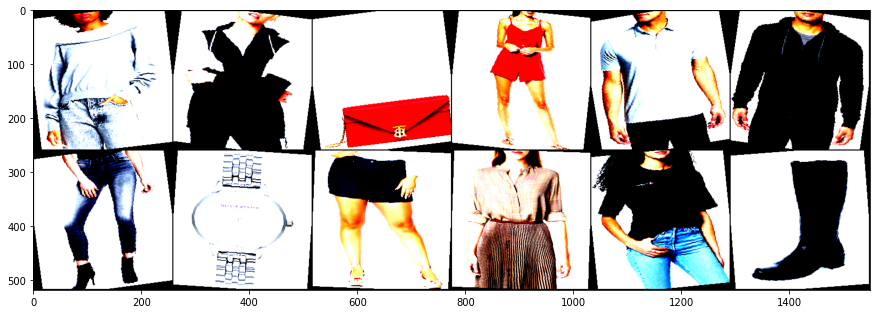

In [ ]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=[15,15])
    plt.imshow(inp)


# Get a batch of training data
images = next(iter(train_loader))

# Make a grid from batch
output = torchvision.utils.make_grid(images[0],nrow=6)

imshow(output)

In [ ]:
#plt.imshow(  (torch.FloatTensor(images[0]/255.)).permute(1, 2, 0)  )

In [ ]:
#plt.imshow( transforms.Compose([normalize])(torch.FloatTensor(images[0]/255.)).permute(1, 2, 0) )

# Model

In [ ]:
#@title Encoder()

class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [ ]:
#@title Attention()
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [ ]:
#@title DecoderWithAttention()
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        #caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
%%capture
!pip install bert_score

In [ ]:
import torch.backends.cudnn as cudnn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
with open("/content/drive/MyDrive/master/project/data/word_map.json", "r") as outfile:
    word_map = json.load(outfile)

#from bert_score import BERTScorer
#scorer = BERTScorer(lang="en", rescale_with_baseline=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title parameters
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 20  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 1000  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
#checkpoint = 'BEST_checkpoint_checkpoint.pth.tar'  # path to checkpoint, None if none
checkpoint = None

train_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'train',
                       transform=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                          std=[0.229, 0.224, 0.225]),
                                                     transforms.RandomHorizontalFlip(),
                                                     transforms.RandomRotation(degrees=(-10, 10))]))
                       ,batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
        CaptionDataset('all_df.csv', 'test', transform=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                                std=[0.229, 0.224, 0.225])])),
        batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
#@title different functions
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.
    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

In [ ]:
#@title main()
def main(train_loader, test_loader, word_map,best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, scorer):
    """
    Training and validation.
    """
    
    rev_word_map = {id: word for word, id in word_map.items()}

    # Initialize / load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Epochs
    for epoch in range(start_epoch, start_epoch+epochs):

        # Decay learning rate if there is no improvement for 6 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 5 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4, recent_loss = validate(val_loader=test_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion,
                                w_map = word_map,
                                rev_w_map = rev_word_map,
                                scorer = scorer)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print(f"\nEpochs since last improvement: {epochs_since_improvement}\n")
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint('checkpoint', epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)
    
    return encoder, decoder

In [ ]:
#@title train
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()
    losses = AverageMeter()  # loss (per word decoded)
    #top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(tqdm(train_loader, desc='train_loader', leave=False)):

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(input=scores, lengths=decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(input=targets, lengths=decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        #top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        #top5accs.update(top5, sum(decode_lengths))

        start = time.time()

        # Print status
        #if i % 1249 == 0:
    print(f'Training: Epoch: [{epoch}], Loss {losses.val:.4f} ({losses.avg:.4f})\t')
                  #f'Top-5 Accuracy {top5accs.val:.3f} ({top5accs.avg:.3f})')


In [ ]:
#@title validate()
def validate(val_loader, encoder, decoder, criterion,w_map, rev_w_map, scorer):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    losses = AverageMeter()
    #top5accs = AverageMeter()

    references = []  # references (true captions) for calculating BLEU-4 score
    hypotheses = []  # hypotheses (predictions)
    

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens) in enumerate(tqdm(val_loader, desc='val_loader', leave=False)):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            #top5 = accuracy(scores, targets, 5)
            #top5accs.update(top5, sum(decode_lengths))


            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            
            for j in range(caps_sorted.shape[0]):
                img_caps = caps_sorted[j].tolist()
                img_captions = [w for w in img_caps if w not in {word_map['<start>'], word_map['<pad>'],
                                                                 word_map['<end>'], word_map['<unk>']}]# remove <>
                references.append([img_captions])

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        #res = dict((v,k) for k,v in word_map.items())
        #references_w = [[res[id] for id in one_ref] for one_ref in references]
        #hypotheses_w = [[res[id] for id in one_hyp] for one_hyp in hypotheses]
        word_references = [' '.join([rev_w_map[i] for i in references_i[0]]) for references_i in references]
        word_hypotheses = [' '.join([rev_w_map[i] for i in hypotheses_i]) for hypotheses_i in hypotheses]
        
        bert_score = scorer.score(word_references,word_hypotheses)[-1].mean()
        bleu4 = corpus_bleu(references, hypotheses)
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
                            #smoothing_function=SmoothingFunction().method4)

        print(f'Validation: BLEU-4 - {bleu4}, LOSS - {losses.avg:.3f}, BERT_SCORE - {bert_score}')
        print(f'(bleu1: {bleu1}, bleu2: {bleu2}, bleu3: {bleu3})')

    return bleu4, losses.avg

In [ ]:
enc, dec = main(train_loader, test_loader, word_map, best_bleu4=0, epochs_since_improvement=0, 
                checkpoint=None, start_epoch=0, fine_tune_encoder=True, scorer=scorer)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage.transform
from PIL import Image
import torch.nn.functional as F

## predicting one descr

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/master/project/BEST_checkpoint_checkpoint.pth(4).tar', map_location=str(device))
decoder = checkpoint['decoder']
encoder = checkpoint['encoder']

### for test data

In [ ]:
descr = pd.read_csv(os.path.join('/content/drive/MyDrive/master/project/data','all_df.csv'),sep=';', index_col=0)
descr.shape

(17988, 7)

In [ ]:
h1 = h5py.File(os.path.join('/content/drive/MyDrive/master/project/data', 'test'+'_images.hdf5'), 'r')
images_test = h1['images_dataset']

glinting goldtone button add a dash of decadence to this sharply tailored blazer patterned with feisty leopard spot


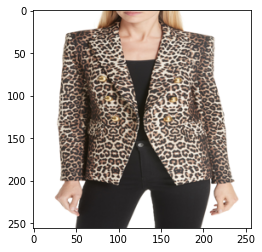

In [ ]:
i = 500

print(descr[descr.train==0].iloc[i]['description'])
plt.imshow(  (torch.FloatTensor(images_test[i]/255.)).permute(1, 2, 0)  );

In [ ]:
descr[descr.train==0].iloc[i]['link']

'https://n.nordstrommedia.com/id/sr3/a1bb9c97-9175-48b3-83cc-52d6b0f43e0f.jpeg'

In [ ]:
image_url = 'https://n.nordstrommedia.com/id/sr3/a1bb9c97-9175-48b3-83cc-52d6b0f43e0f.jpeg'
k=1
num=30

In [ ]:
#@title

image_path = 'picture.png'
from urllib.request import urlretrieve
urlretrieve(image_url, image_path)

img = np.array(Image.open(image_path).convert('RGB'))
img = cv2.resize(img, (256, 256))

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

img = transform(img)

# encode the image
encoder_out = encoder(img.unsqueeze(0).to(device))     # (1, enc_image_size, enc_image_size, encoder_dim)
enc_image_size = encoder_out.size(1)
encoder_dim = encoder_out.size(3)

# flatten encoded image representation
encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
num_pixels = encoder_out.size(1)

# we'll treat the problem as having a batch size of k
encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

# tensor to store top k previous words at each step; now they're just <start>
top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # tensor to store top k sequences; now they're just <start>
top_k_seqs = top_k_prev_words   # (k, 1)

    # tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # tensor to store top k sequences' alphas; now they're just 1s
top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # lists to store completed sequences along with their alphas and scores
complete_seqs = []
complete_seqs_alpha = []
complete_seqs_scores = []

In [ ]:
#@title
vocab_size = len(word_map)
h, c = decoder.init_hidden_state(encoder_out)
top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)

for i in range(num):
    embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)
    attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)
    alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (s, enc_image_size, enc_image_size)
    gate = F.sigmoid(decoder.f_beta(h))      # gating scalar, (s, encoder_dim)
    attention_weighted_encoding = gate * attention_weighted_encoding

    h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
            )   # (s, decoder_dim)

    scores = decoder.fc(h)      # (s, vocab_size)
    scores = F.log_softmax(scores, dim=1)
    # add the scores to prev scores
    scores = top_k_scores.expand_as(scores) + scores
    # unroll and find top scores, and their unrolled indices
    top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
    # convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words // vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size
    # add new words to sequences, alphas
    top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)    # (s, step + 1)
    top_k_seqs_alpha = torch.cat(
                [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
            )   # (s, step + 1, enc_image_size, enc_image_size)
    # which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                            if next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # set aside complete sequences
    if len(complete_inds) > 0:
            print('hey')
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
    k -= len(complete_inds)  # reduce beam length accordingly

    top_k_seqs = top_k_seqs[incomplete_inds]
    top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

complete_seqs.extend(top_k_seqs[incomplete_inds].tolist())
complete_seqs_alpha.extend(top_k_seqs_alpha[incomplete_inds].tolist())
complete_seqs_scores.extend(top_k_scores[incomplete_inds])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [ ]:
# id to word mapping
rev_word_map = {id: word for word, id in word_map.items()}
top_k_seqs

tensor([[6002,   21, 1163,  322,    3,   88,  141,  239,  297,   98,   40,  875,
           43,    5,  261,  502,   38,   12,   21,  187, 2014,  197,  702,   34,
           21, 1163,  322,    3, 1163,  401,   67]])

In [ ]:
' '.join([rev_word_map[int(i)] for i in top_k_seqs[0]])

'<start> a leopard print and slightly cropped hem add to the charm of this tailored jacket cut from a double face italian silk with a leopard print and leopard pattern that'

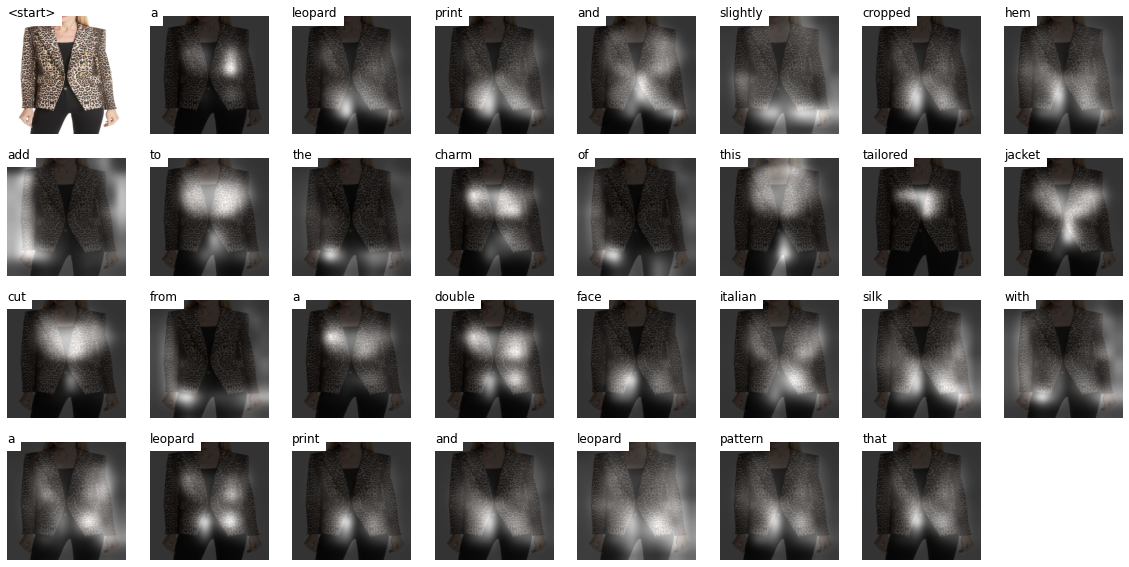

In [ ]:
#@title
seq = complete_seqs[0]
alphas = complete_seqs_alpha[0]

caption = [rev_word_map[ind] for ind in seq]

img = Image.open(image_path).convert('RGB')
img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

# plot the image and attention map
fig = plt.figure(figsize=(20, 10))
for t in range(len(caption)):
        
        plt.subplot(int(np.ceil(len(caption) / 8.)), 8, t + 1)
        plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(img)

        current_alpha = alphas[t]
        alpha = skimage.transform.pyramid_expand(np.array(current_alpha), upscale=24, sigma=8)
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        
        plt.set_cmap('gray')
        plt.axis('off')

plt.show()

### for new data

In [ ]:
image_url = 'https://st.tsum.com/btrx/i/11/86/04/79/01_1526.jpg?u=1615293433' 
image_url = 'https://cdn.childrensalon.com/media/catalog/product/cache/0/image/1000x1000/9df78eab33525d08d6e5fb8d27136e95/g/u/gucci-girls-white-leather-trainers-281511-c127005f7a1c1f4e6ea3a476928fe449f6691716.jpg'
n=30

In [ ]:
#@title

image_path = 'picture.png'
from urllib.request import urlretrieve
urlretrieve(image_url, image_path)

img = np.array(Image.open(image_path).convert('RGB'))
img = cv2.resize(img, (256, 256))

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

img = transform(img)
k=1
# encode the image
encoder_out = encoder(img.unsqueeze(0).to(device))     # (1, enc_image_size, enc_image_size, encoder_dim)
enc_image_size = encoder_out.size(1)
encoder_dim = encoder_out.size(3)

# flatten encoded image representation
encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
num_pixels = encoder_out.size(1)

# we'll treat the problem as having a batch size of k
encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

# tensor to store top k previous words at each step; now they're just <start>
top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # tensor to store top k sequences; now they're just <start>
top_k_seqs = top_k_prev_words   # (k, 1)

    # tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # tensor to store top k sequences' alphas; now they're just 1s
top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # lists to store completed sequences along with their alphas and scores
complete_seqs = []
complete_seqs_alpha = []
complete_seqs_scores = []

In [ ]:
#@title
step = 1
vocab_size = len(word_map)
h, c = decoder.init_hidden_state(encoder_out)
top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)

for i in range(n):
    embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)
    attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)
    alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (s, enc_image_size, enc_image_size)
    gate = F.sigmoid(decoder.f_beta(h))      # gating scalar, (s, encoder_dim)
    attention_weighted_encoding = gate * attention_weighted_encoding

    h, c = decoder.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
            )   # (s, decoder_dim)

    scores = decoder.fc(h)      # (s, vocab_size)
    scores = F.log_softmax(scores, dim=1)
    # add the scores to prev scores
    scores = top_k_scores.expand_as(scores) + scores
    # unroll and find top scores, and their unrolled indices
    top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
    # convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words // vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size
    # add new words to sequences, alphas
    top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)    # (s, step + 1)
    top_k_seqs_alpha = torch.cat(
                [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
            )   # (s, step + 1, enc_image_size, enc_image_size)
    # which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                            if next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # set aside complete sequences
    if len(complete_inds) > 0:
            print('hey')
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
    k -= len(complete_inds)  # reduce beam length accordingly

    top_k_seqs = top_k_seqs[incomplete_inds]
    top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

complete_seqs.extend(top_k_seqs[incomplete_inds].tolist())
complete_seqs_alpha.extend(top_k_seqs_alpha[incomplete_inds].tolist())
complete_seqs_scores.extend(top_k_scores[incomplete_inds])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [ ]:
# id to word mapping
rev_word_map = {id: word for word, id in word_map.items()}
top_k_seqs

tensor([[6002,   21,  715,  667,   10,  341,   12,   21,   60,  772,   31,   34,
           21,  715,  404,   28,    3,   21,  715, 4003,   28,  157,  715,  668,
          196,    3,   21,   59, 4003, 3591, 1000]])

In [ ]:
' '.join([rev_word_map[int(i)] for i in top_k_seqs[0]])

'<start> a sporty sneaker is made from a soft suede knit with a sporty contrast sole and a sporty bumper sole for sporty street style and a signature bumper cupsole sporting'

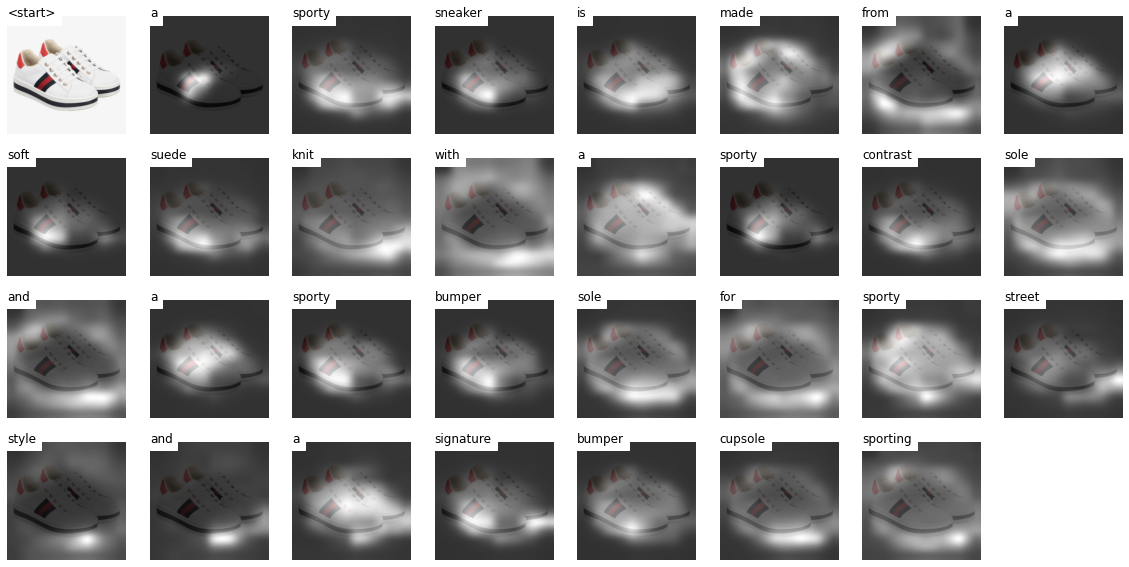

In [ ]:
seq = complete_seqs[0]
alphas = complete_seqs_alpha[0]

caption = [rev_word_map[ind] for ind in seq]

img = Image.open(image_path).convert('RGB')
img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

# plot the image and attention map
fig = plt.figure(figsize=(20, 10))
for t in range(len(caption)):
        
        plt.subplot(int(np.ceil(len(caption) / 8.)), 8, t + 1)
        plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(img)

        current_alpha = alphas[t]
        alpha = skimage.transform.pyramid_expand(np.array(current_alpha), upscale=24, sigma=8)
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        
        plt.set_cmap('gray')
        plt.axis('off')

plt.show()

In [ ]:
def generate_image_caption(encoder, decoder, image_path, word_map, beam_size=5):
    """
    Reads an image and captions it with beam search as well as plot attention maps.
    """
    k = beam_size
    
    # id to word mapping
    rev_word_map = {id: word for word, id in word_map.items()}

    # read and pre-process image
    img = np.array(Image.open(image_path).convert('RGB'))
    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (256, 256))

    # sanity check
    assert img.shape == (256, 256, 3)
    assert np.max(img) <= 255

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = transform(img)    # (3, 256, 256)

    # encode the image
    encoder_out = encoder(img.unsqueeze(0).to(device))     # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # flatten encoded image representation
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # we'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)    # (k, num_pixels, encoder_dim)

    # tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)   # (k, 1)

    # tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words   # (k, 1)

    # tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)     # (k, 1)

    # tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # lists to store completed sequences along with their alphas and scores
    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)
    print(top_k_prev_words)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)
        

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)     # (s, enc_image_size, enc_image_size)

        gate = F.sigmoid(decoder.f_beta(h))      # gating scalar, (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c)
        )   # (s, decoder_dim)

        scores = decoder.fc(h)      # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # add the scores to prev scores
        scores = top_k_scores.expand_as(scores) + scores    # (s, vocab_size)

        # all the k points will have the same score for the first step (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
        else:
            # unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
        
        # convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)    # (s, step + 1)
        top_k_seqs_alpha = torch.cat(
            [top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1
        )   # (s, step + 1, enc_image_size, enc_image_size)
        
        # which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) 
                            if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # proceed with incomplete sequences
        if k == 0:
            break
        
        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # break if things have been going on too long
        if step > 50:
            break
        step += 1
    
    # select sequence with max score
    print(complete_seqs_scores)
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    caption = [rev_word_map[ind] for ind in seq]

    img = Image.open(image_path).convert('RGB')
    img = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    # plot the image and attention map
    fig = plt.figure(figsize=(20, 8))
    for t in range(len(caption)):
        
        plt.subplot(np.ceil(len(caption) / 5.), 5, t + 1)
        plt.text(0, 1, '%s' % (caption[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(img)

        current_alpha = alphas[t]
        alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        
        plt.set_cmap('gray')
        plt.axis('off')

    plt.show()


In [ ]:
image_url = 'https://st.tsum.com/btrx/i/11/86/04/79/01_1526.jpg?u=1615293433' #@param {type:"string"}
beam_size =  10 #@param {type: "number"}

vocab_size = len(word_map)
image_path = 'picture.png'

from urllib.request import urlretrieve
urlretrieve(image_url, image_path)

generate_image_caption(encoder, decoder, image_path, word_map, beam_size)

tensor([[6002],
        [6002],
        [6002],
        [6002],
        [6002],
        [6002],
        [6002],
        [6002],
        [6002],
        [6002]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[]


ValueError: ignored

In [ ]:
beam_size =  "" #@param {type: "string"}

# Plots

In [ ]:
tr_loss = [6.8679,5.8781,5.4133,5.118,4.8911,4.7077,4.5484,4.4068,4.2744,4.1504,4.0278,
           3.9108,3.7906,3.6742,3.561,3.4463,3.3304,3.2141,3.1038,2.9976,2.8966,
           2.7962,2.698,2.5474,2.4435,2.3642,2.2907,2.2189,2.197,2.0278,1.9204,1.8698]

In [ ]:
a = [[0.01213,6.042,-0.13027,0.24265,0.09161,0.03234],[0.02405,5.485,-0.00634,0.29479,0.12606,0.05416],
      [0.03373,5.202,0.02935,0.31763,0.14401,0.06819],[0.04039,5.015,0.06691,0.3367,0.15972,0.07977],
     [0.04492,4.896,0.08649,0.34739,0.16843,0.08631],[0.04989,4.814,0.10057,0.35462,0.17605,0.09313],
      [0.05349,4.755,0.11225,0.35787,0.18152,0.09777],[ 0.056025, 4.718,0.11693,0.363949,0.1860626,0.1014605],
     [0.05724549,4.686,0.120992,0.36718,0.1890288,0.103449],[0.05921,4.673,0.129625,0.367053,0.190033,0.105375],
     [0.062311,4.657,0.1299062, 0.3710,0.19373,0.10858],[0.062299,4.665,0.132505,0.370412,0.1944095,0.1093641],
     [0.065106,4.667,0.130904,0.37186,0.19533,0.111166],[0.06392,4.678,0.135468,0.370762,0.1949476,0.1102879], #13
     [0.06378,4.704,0.13789,0.37095, 0.19463,0.110169], [0.0639861,4.731,0.1354843,0.3686612,0.193599,0.1097258],
     [0.0659819,4.748,0.140903,0.372115,0.196495,0.1124068], [0.066353,4.799,0.133245,0.36689,0.1933888,0.1116241],
     [0.065277,4.827,0.135466,0.366735,0.1929336,0.110586],[0.063965,4.869,0.135801,0.366432,0.192488,0.109579],
     [0.062719,4.921,0.132364,0.36243, 0.18910,0.107309],[0.065324,4.953,0.136344,0.36328,0.189792,0.1093012],
     [0.064341,5.008,0.134249,0.3618,0.18926,0.10859], [0.062784,5.056,0.130504,0.358999,0.186428,0.106246],#23
     [0.06446, 5.101,0.13384,0.36038,0.18714,0.10754], [0.06259,5.164,0.135208,0.35718,0.18522,0.10567],
     [0.062927,5.208,0.13458,0.356134,0.18478,0.10545], [0.063527, 5.263,0.13041,0.354892,0.183829, 0.105833],
     [0.06242,5.307,0.12952,0.352552,0.18146,0.10372], [0.06056,5.362,0.13089,0.351071,0.18003,0.102459],
     [0.059858,5.457,0.1234519,0.348668,0.17770,0.100617], [0.061337,5.506,0.125009,0.348636,0.1791497,0.102394]
     ]

In [ ]:
import pandas as pd

In [ ]:
res = pd.DataFrame(a)
res.columns = ['bleu4','val_loss','bert_score','bleu1','bleu2','bleu3']
res['train_loss'] = tr_loss

res.head()

,bleu4,val_loss,bert_score,bleu1,bleu2,bleu3,train_loss
0,0.01213,6.042,-0.13027,0.24265,0.09161,0.03234,6.8679
1,0.02405,5.485,-0.00634,0.29479,0.12606,0.05416,5.8781
2,0.03373,5.202,0.02935,0.31763,0.14401,0.06819,5.4133
3,0.04039,5.015,0.06691,0.33670,0.15972,0.07977,5.1180
4,0.04492,4.896,0.08649,0.34739,0.16843,0.08631,4.8911


In [ ]:
import seaborn as sns

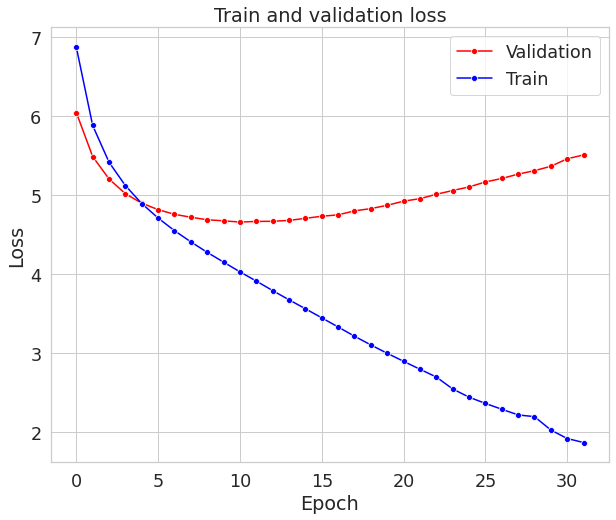

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")


ax = sns.lineplot(x=range(32),y=res['val_loss'], marker='o', color='red', label='Validation')
sns.lineplot(x=range(32),y=res['train_loss'], marker='o', color='blue', label='Train')

ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Train and validation loss')
sns.set(rc={"lines.linewidth": 3})

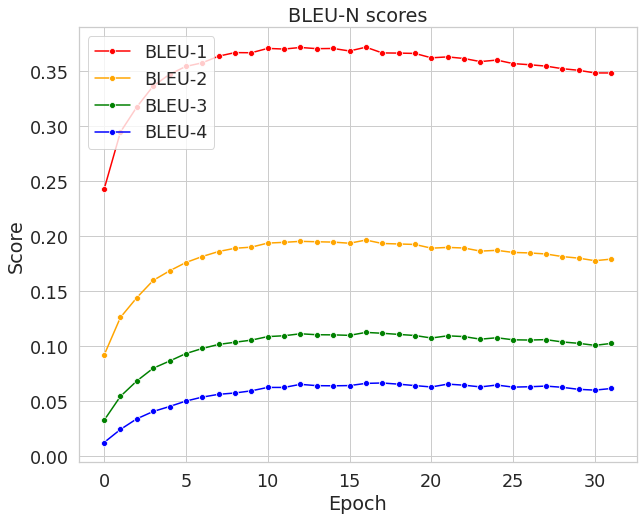

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")



ax = sns.lineplot(x=range(32),y=res['bleu1'], marker='o', color='red', label='BLEU-1')
sns.lineplot(x=range(32),y=res['bleu2'], marker='o', color='orange', label='BLEU-2')
sns.lineplot(x=range(32),y=res['bleu3'], marker='o', color='green', label='BLEU-3')
sns.lineplot(x=range(32),y=res['bleu4'], marker='o', color='blue', label='BLEU-4')

ax.set(xlabel='Epoch', ylabel='Score')
ax.set_title('BLEU-N scores')
sns.set(rc={"lines.linewidth": 3})

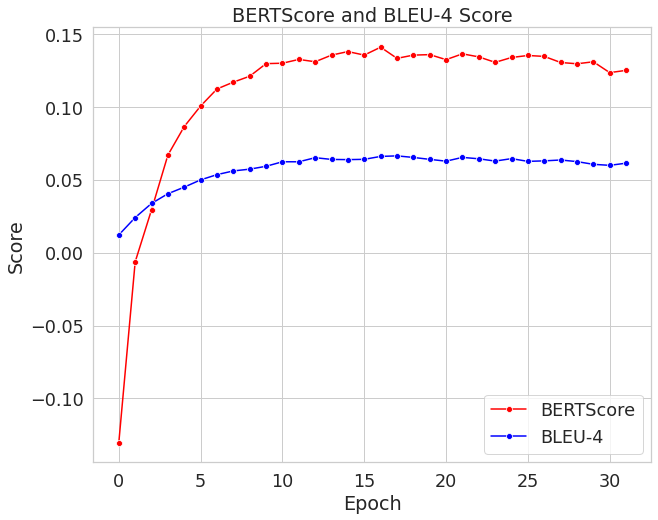

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

ax = sns.lineplot(x=range(32),y=res['bert_score'], marker='o', color='red', label='BERTScore')
sns.lineplot(x=range(32),y=res['bleu4'], marker='o', color='blue', label='BLEU-4')

ax.set(xlabel='Epoch', ylabel='Score')
ax.set_title('BERTScore and BLEU-4 Score')
sns.set(rc={"lines.linewidth": 3})